In [1]:
import numpy as np
from astropy.table import Table, Column, join
from astropy.coordinates import SkyCoord
from astropy.table import Column
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.wcs import WCS
from astropy.io import fits
from matplotlib.colors import LogNorm
from astropy.utils.data import download_file
import warnings
import os

warnings.filterwarnings('ignore')

homedir = os.getenv("HOME")
catalog_path='/Users/EvanB.LAPTOP-8CHCIOMA/Downloads/2024-04-25-20240907T013110Z-001/2024-04-25/'

In [2]:
#os.listdir(catalog_path)

In [3]:
%run ~/Downloads/readtablesv2.py --help

usage: readtablesv2.py [-h] [--tabledir TABLEDIR] [--tableprefix TABLEPREFIX]

Read in all virgo filament tables

options:
  -h, --help            show this help message and exit
  --tabledir TABLEDIR   directory where tables are stored
  --tableprefix TABLEPREFIX
                        prefix for tables; default is vf_v2


In [4]:
%run ~/Downloads/readtablesv2.py --tabledir $catalog_path

In [5]:
# Tables
myTab = v.main 
myTab2 =Table.read(catalog_path+'vf_v2_r_photometry.fits')

In [6]:
def Local_Density(cuttab):
    ra = np.array(cuttab['RA']) # Right ascension of each galaxy
    dec = np.array(cuttab['DEC']) # Declination of each galaxy
    vtarg = np.array(cuttab['vr'])

    points = []
    for i in range(len(dec)):
        points.append((ra[i],dec[i])) # Array of tuples of ra and dec (each galaxy now represented by a point)

    def distance(ra1, dec1, ra2, dec2):
        return np.sqrt(((ra1 - ra2)*np.cos(dec1-dec2))**2 + (dec1 - dec2)**2) # Distance between two points    

    def Five_Nearest(points, target, K):
        pts = []
        n = len(points)
        d = []
 
        for i in range(n):
            j = i-1
            if (abs(vtarg[i] - vtarg[j]) < 300): # Compares the velocity of each galaxy to the next and records it if it is within +/- 300 km/s
                d.append({
                    "first": distance(points[i][0], points[i][1], target[0], target[1]), # Finds distance between target point and another point
                    "second": i # Stores new point that had its distance relative to the target found
                })
     
        d = sorted(d, key=lambda l:l["first"]) # Sorts d from smallest to largest distance for each target point
 
        for i in range(K): # Loops through for however many times are specified by K (I will use K=6)
            pt = []
            pt.append(points[d[i]["second"]][0]) # First element of a tuple in an array of nearest points sorted by distance
            pt.append(points[d[i]["second"]][1]) # Second element of a tuple in an array of nearest points sorted by distance
            pts.append(pt) # Stores all individual pt values as tuples
 
        return pts # Returns the six nearest galaxies to a target galaxy (the first of which is the original target galaxy)


    # Find five nearest galaxies to each galaxy
    five_nn = [] # Store nearest neighbors

    K = 6 # Number of times to calculate nearest neighbors 
    for i in range(len(points)):
        target = points[i] # Switches target point
        for pt in Five_Nearest(points, target, K): # Calculates five nearest points for each points in points and stores them along with their targets
            five_nn.append((pt[0], pt[1])) # Includes six points for each target, the first of which in each set is the target itself\

    # Separating target points from fifth nearest points
    target_fnn = np.array(points) # list of original target galaxies
    five_nn = np.array(five_nn)

    fifth_nearest_neighbors = np.array(five_nn[5::6]) # fifth nearest point of each target


    # Finding angular distance
    dist_fifthnn = []
    
    # Calculates angular distance between each galaxy and its fifth nearest meighbor
    for i in range(len(points)):
        target0 = target_fnn[i] # Changes target on each loop through
        dist_fifthnn.append(distance(fifth_nearest_neighbors[i][0], fifth_nearest_neighbors[i][1], target0[0], target0[1])) # Produces distance array
 
    angle = np.array(dist_fifthnn)

    # Finds velocity of each of the five nearest neighbors
    v = []
    for i in range(len(fifth_nearest_neighbors)):
        for j in range(len(points)): 
            if (fifth_nearest_neighbors[i][0] == points[j][0]) & (fifth_nearest_neighbors[i][1] == points[j][1]):
                v.append(cuttab['vr'][j])

    # Convert angles in degrees to radians
    radians = (np.pi/180)*(angle)

    # Finding distance, in m, between the Sun and the galaxies
    H0 = 2.47*10**(-18) #/s 

    d = (np.array(v)*1000)/H0 #m

    # Using small angle approximation to convert to Mpc
    r_5 = ((d*radians)*(3.24*10**(-23))) #Mpc


    # Find fifth nearest neighbor density
    sigma_5 = 1/(r_5**2)
    
    return sigma_5

In [7]:
# Catalog cuts from Castignani

# RA cut
raTab = myTab['RA']
ramax = 280
ramin = 100
raflag = (raTab>ramin) & (raTab<ramax)

# DEC cut
decTab = myTab['DEC']
decmin = -1.3
decmax = 75
decflag = (decTab>decmin) & (decTab<decmax)

# Magnitude cut
Mr = myTab2['M_r']
Mrmax = -15.7
Mrflag = (Mr < Mrmax) #(Mr > Mrmin)

# Velocity cut
vr = myTab['vr']
vflag = (vr < 3300) & (vr > 500)

cut = raflag & decflag & Mrflag & vflag 

cuttab = myTab[cut]

In [8]:
print(len(cuttab))

3455


In [9]:
sigma_5 = Local_Density(cuttab)

In [10]:
# Reads in Environment table that contains local density values
envTab=Table.read(catalog_path+'vf_v2_environment.fits')

In [11]:
# Applying same cuts to environment table
envcuttab = envTab[cut]

In [12]:
#envcuttab.colnames

In [13]:
my_sigma_5 = sigma_5
vfs_sigma_5 = envcuttab['n5th_2D'] # Local density from vfs

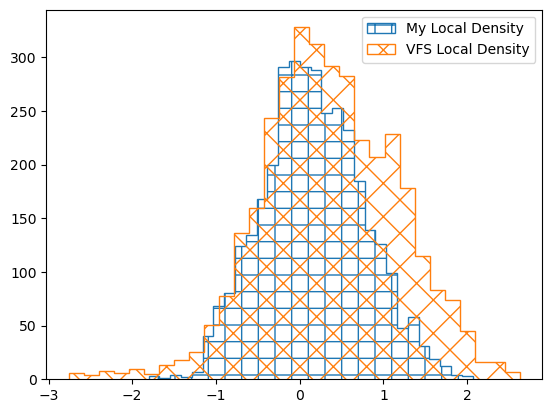

In [14]:
plt.hist(np.log10(my_sigma_5),label='My Local Density',histtype='step',bins=30,hatch='+')
plt.hist(np.log10(vfs_sigma_5),label='VFS Local Density',histtype='step',bins=30,hatch='x')

plt.legend()

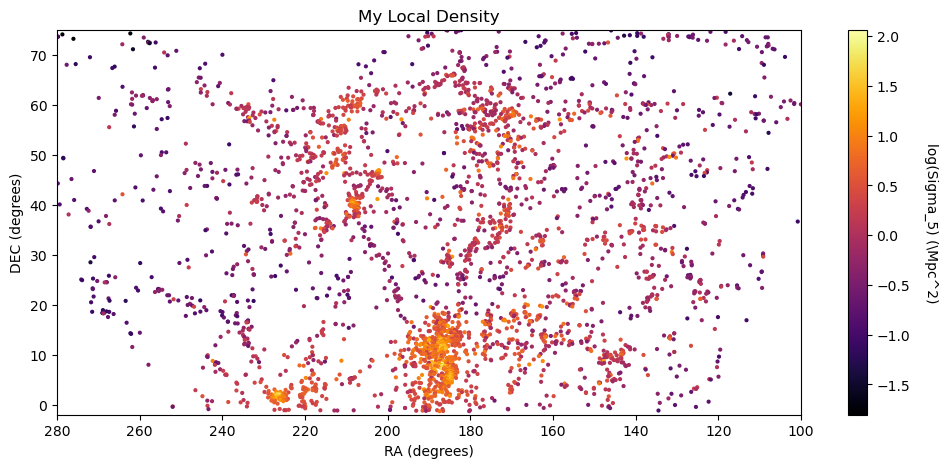

In [15]:
# My local density plot

ra1 = cuttab['RA']
dec1 = cuttab['DEC']
ccode1 = np.log10(my_sigma_5)

#Plot RA vs DEC and color it by recessional velocity
plt.figure(figsize=(12,5))
plt.scatter(ra1,dec1,c=ccode1,cmap='inferno',s=4)
plt.xlim(reversed(plt.xlim()))
plt.title('My Local Density')
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.xlim(280,100)
plt.ylim(-2,75)
cbar = plt.colorbar()
#plt.clim(-2.9,2.7)
cbar.set_label('log(Sigma_5) (\Mpc^2)',rotation=270,labelpad=20)

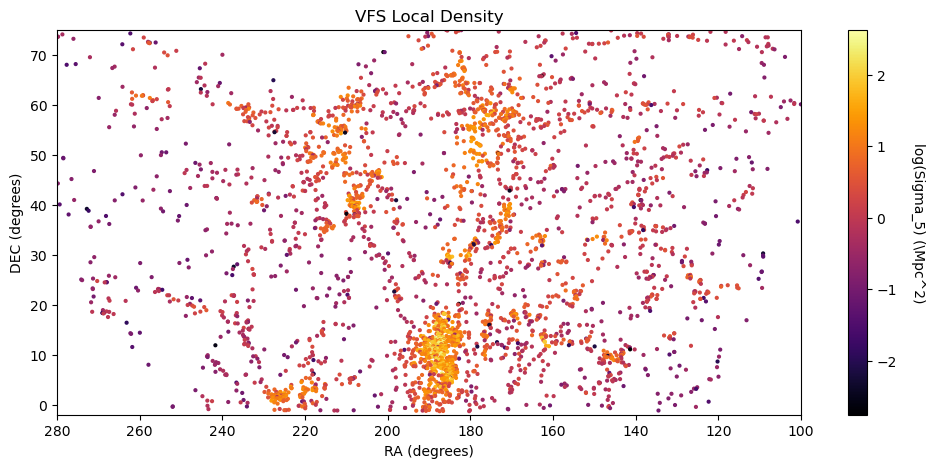

In [16]:
# VFS local density plot

ra2 = cuttab['RA']
dec2 = cuttab['DEC']
ccode2 = np.log10(vfs_sigma_5)

#Plot RA vs DEC and color it by recessional velocity
plt.figure(figsize=(12,5))
plt.scatter(ra2,dec2,c=ccode2,cmap='inferno',s=4) # ,alpha=0.8
plt.xlim(reversed(plt.xlim()))
plt.title('VFS Local Density')
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.xlim(280,100)
plt.ylim(-2,75)
cbar = plt.colorbar()
cbar.set_label('log(Sigma_5) (\Mpc^2)',rotation=270,labelpad=20)

In [17]:
print(median(my_sigma_5))
print(median(vfs_sigma_5))

1.3761235629357949
2.0894502970453495


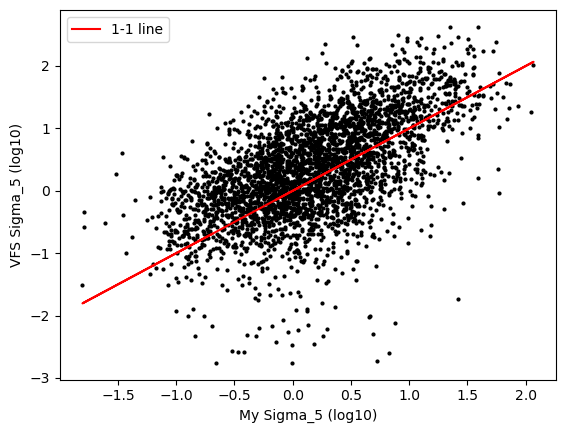

In [18]:
x = np.log10(my_sigma_5)
y = np.log10(vfs_sigma_5)

#calculate equation for trendline
z = np.polyfit(x, x, 1)
p = np.poly1d(z)

#z2 = np.polyfit(x, y, 1)
#p2 = np.poly1d(z)

line = np.array(p(x))
plt.scatter(x, y, s=4, color='black')
plt.xlabel('My Sigma_5 (log10)')
plt.ylabel('VFS Sigma_5 (log10)')

#add trendline to plot
plt.plot(x,p(x),color='r',label='1-1 line')
#plt.plot(x,p2(x),label='Trendline', linestyle='dashed')
plt.legend()